In [63]:
import torch
import numpy as np
import gpytorch 
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
import seaborn as sns 
sns.set_style("whitegrid")
from torch.distributions import constraints, transform_to
import torch.autograd as autograd
import torch.optim as optim
# Set the radom seed 
torch.manual_seed(42)

# Gaussian Processes 

1. Create a generic class for GP
2. Make a likelyhood function
3. Priors on the Mean and covariance 
4. Define the kernel 

In [2]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        wn_variances = torch.randn(train_x.shape[0])
        self.covr_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covr_x = self.covr_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covr_x)

In [3]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * np.pi)) + torch.randn(train_x.size()) * 0.50

In [4]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    """
        print('Iter %d/%d - Loss: %.3f  log_noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    """
    optimizer.step()

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

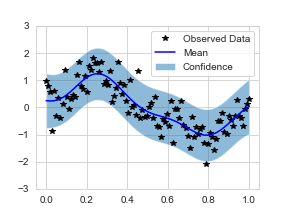

In [7]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [8]:
observed_pred.stddev

tensor([0.5044, 0.4920, 0.4848, 0.4813, 0.4800, 0.4797, 0.4797, 0.4797, 0.4795,
        0.4793, 0.4791, 0.4790, 0.4790, 0.4790, 0.4790, 0.4790, 0.4790, 0.4790,
        0.4790, 0.4790, 0.4790, 0.4790, 0.4790, 0.4789, 0.4789, 0.4789, 0.4789,
        0.4789, 0.4789, 0.4790, 0.4790, 0.4790, 0.4790, 0.4790, 0.4790, 0.4790,
        0.4790, 0.4790, 0.4790, 0.4790, 0.4791, 0.4793, 0.4795, 0.4796, 0.4797,
        0.4797, 0.4800, 0.4813, 0.4848, 0.4920, 0.5044])

So GP effectively captures the uncertanity/error bar on input gaussian noise. 

# Let us do bayesian optimization using these GP.

1. Define a acquision function for the next sample point 
2. Sample the objective function 
3. Augument the GP with the new data.

In [36]:
# Expected improvement
def expected_improvement(x_new):
    x_sampled = test_x 
    xi=0.01
    x_new = torch.from_numpy(x_new).float()
    # Compute the mean of sampled points 
    observed_sam = likelihood(model(x_sampled))
    mean_sam = observed_sam.mean.detach().requires_grad_(False)
    # Compute the mean and covariance of new data
    observed_new = likelihood(model(x_new))
    mean_new = observed_new.mean.detach().requires_grad_(False)
    vari_new = observed_new.variance.detach().requires_grad_(False)
    
    nrml = torch.distributions.normal.Normal(0.0, 1.0)
    max_mean = mean_sam.max()
    Z = (mean_new - max_mean - xi)/vari_new
    if bool((vari_new > 0.0).numpy()):
        return float(((mean_new - max_mean - xi)*nrml.cdf(Z) + vari_new*torch.exp(nrml.log_prob(Z))).numpy())
    else:
        return 0.0

In [50]:
from scipy.optimize import minimize, Bounds

In [51]:
b =  Bounds(0, 1)
x0 = np.asarray([0.21])
x0 = torch.from_numpy(x0)
minimize(expected_improvement, x0, bounds=b, method="L-BFGS-B")

      fun: 4.132539288548287e-08
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([1.])

In [55]:
with x as 10:
    print(x)

SyntaxError: can't assign to literal (<ipython-input-55-c7483d435cbd>, line 1)

In [80]:
def EI(x_new):
    x_sampled = test_x 
    xi=0.01
    # Compute the mean of sampled points 
    observed_sam = likelihood(model(x_sampled))
    mean_sam = observed_sam.mean
    # Compute the mean and covariance of new data
    observed_new = likelihood(model(x_new))
    mean_new = observed_new.mean
    vari_new = observed_new.variance
    
    nrml = torch.distributions.normal.Normal(0.0, 1.0)
    max_mean = mean_sam.max()
    Z = (mean_new - max_mean - xi)/vari_new
    if bool((vari_new > 0.0).numpy()):
        return (mean_new - max_mean - xi)*nrml.cdf(Z) + vari_new*torch.exp(nrml.log_prob(Z))
    else:
        return (mean_new - max_mean - xi)*nrml.cdf(Z) + vari_new*torch.exp(nrml.log_prob(Z)) * 0.0
    
def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x])

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = EI(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

In [81]:
find_a_candidate(x0.float(), 0, 1)

tensor([0.0730])